In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Redirect to dataset folder
%cd /content/drive/MyDrive/Colab Notebooks/project_baselearning

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/project_baselearning


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd

# อ่าน CSV ด้วยการเข้ารหัสที่แตกต่างกัน
try:
    data = pd.read_csv("AirlineReview.csv", encoding='utf-8')
except UnicodeDecodeError:
    try:
        data = pd.read_csv("AirlineReview.csv", encoding='latin-1')
    except UnicodeDecodeError:
        try:
            data = pd.read_csv("AirlineReview.csv", encoding='cp1252')
        except UnicodeDecodeError:
            pass

In [ ]:
print(data.head())

          ID                                               text
0  681448150                @VirginAmerica What @dhepburn said.
1  681448153  @VirginAmerica plus you've added commercials t...
2  681448156  @VirginAmerica I didn't today... Must mean I n...
3  681448158  @VirginAmerica it's really aggressive to blast...
4  681448159  @VirginAmerica and it's a really big bad thing...


**จำแนก**

In [ ]:
# แยกข้อความที่มี @ (ทุกข้อความที่ขึ้นต้นด้วย @) ออกไปในคอลัมน์ 'Airline'
data['Airline'] = data['text'].str.extract(r'(@\w+)')

# ลบข้อความที่มี @ (ทุกข้อความที่ขึ้นต้นด้วย @) ออกจากข้อความในคอลัมน์ 'text'
data['text'] = data['text'].str.replace(r'@\w+', '', regex=True)

# ลบช่องว่างเกินหลังการลบ @ ออก
data['text'] = data['text'].str.strip()

# แสดง DataFrame หลังการประมวลผล
print(data)

             ID                                               text  \
0     681448150                                        What  said.   
1     681448153  plus you've added commercials to the experienc...   
2     681448156  I didn't today... Must mean I need to take ano...   
3     681448158  it's really aggressive to blast obnoxious "ent...   
4     681448159           and it's a really big bad thing about it   
...         ...                                                ...   
9995  681677617  merged airlines do not work for FF programs. V...   
9996  681677618  You don't have those abilities anywhere! Not a...   
9997  681677619  when you strand someone in a city without lugg...   
9998  681677620  needs to get their shit together. 2 counter pe...   
9999  681677621  I know your policy. Just asking for a little k...   

             Airline  
0     @VirginAmerica  
1     @VirginAmerica  
2     @VirginAmerica  
3     @VirginAmerica  
4     @VirginAmerica  
...              ... 

หาค่า **Positive Negative Neutral**

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# สร้างตัววิเคราะห์ Sentiment
sia = SentimentIntensityAnalyzer()

# วิเคราะห์ Sentiment ด้วย VADER
def sentiment_word(text):
    if pd.isna(text):
        return "Neutral"
    score = sia.polarity_scores(text)
    if score['compound'] > 0:
        return "Positive"
    elif score['compound'] < 0:
        return "Negative"
    else:
        return "Neutral"

**แสดงผล**

In [ ]:
# สร้างคอลัมน์ใหม่ 'Sentiment' สำหรับจำแนก Positive, Negative, Neutral
data['Sentiment'] = data['text'].apply(get_sentiment)

# นับจำนวนข้อความที่เป็น Positive, Negative, Neutral ทั้งหมด
sentiment_counts_all = data['Sentiment'].value_counts()

# นับจำนวนข้อความที่เป็น Positive, Negative, Neutral แยกตาม Airline
sentiment_counts = data.groupby(['text', 'Sentiment']).size().unstack().fillna(0)
sentiment_counts_airline = data.groupby(['Airline', 'Sentiment']).size().unstack().fillna(0)


# แสดงผลการนับทั้งหมด
print(sentiment_counts)
print(sentiment_counts_airline)

Sentiment                                           Negative  Neutral  \
text                                                                    
! THE WORST in customer service.  ! Calling for...       1.0      0.0   
!!!!! YAAYY!!! YAY PROM!!!! http://t.co/DXicoyioxF       0.0      1.0   
"...you in the 10 hrs we were hanging out there...       1.0      0.0   
"Able"? Does that mean not having private conve...       0.0      0.0   
"Airport snow removal method #22.."\nKeep up th...       0.0      0.0   
...                                                      ...      ...   
ÛÏ: WeÛªre looking for our next #FlyingItForw...       0.0      0.0   
ÛÏ:Southwest mobile boarding passes now availa...       0.0      0.0   
ÛÏ:You've met your match.Got status on another...       0.0      1.0   
ÛÏInconvenientÛ is such a convenient word.            0.0      2.0   
ÛÜ is flying from Love to Austin now. That is ...       0.0      0.0   

Sentiment                                         

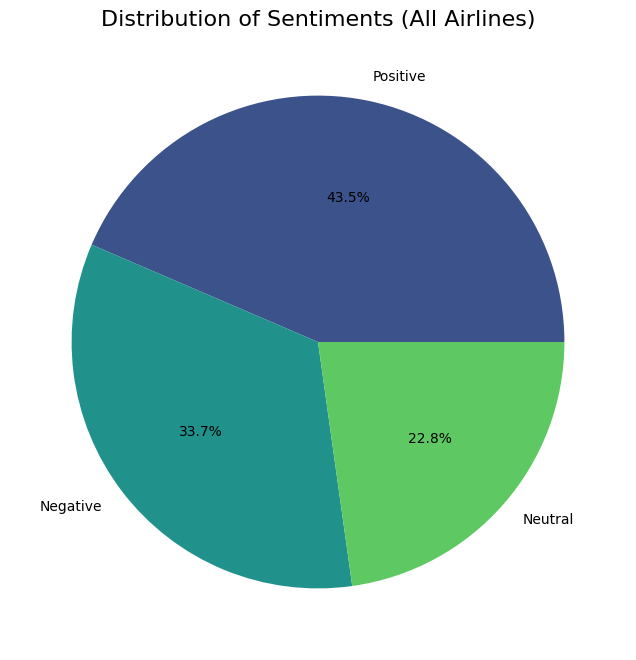

sentiment
Positive    4354
Negative    3368
Neutral     2278
Name: count, dtype: int64


In [ ]:
# 1. การแสดงผล Sentiment สำหรับข้อมูลทั้งหมด

plt.figure(figsize=(8, 8))
plt.pie(total_sentiment_counts, labels=total_sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(total_sentiment_counts)))
plt.title('Distribution of Sentiments (All Airlines)', fontsize=16)
plt.show()

total_sentiment_counts = data['sentiment'].value_counts()
print(total_sentiment_counts )

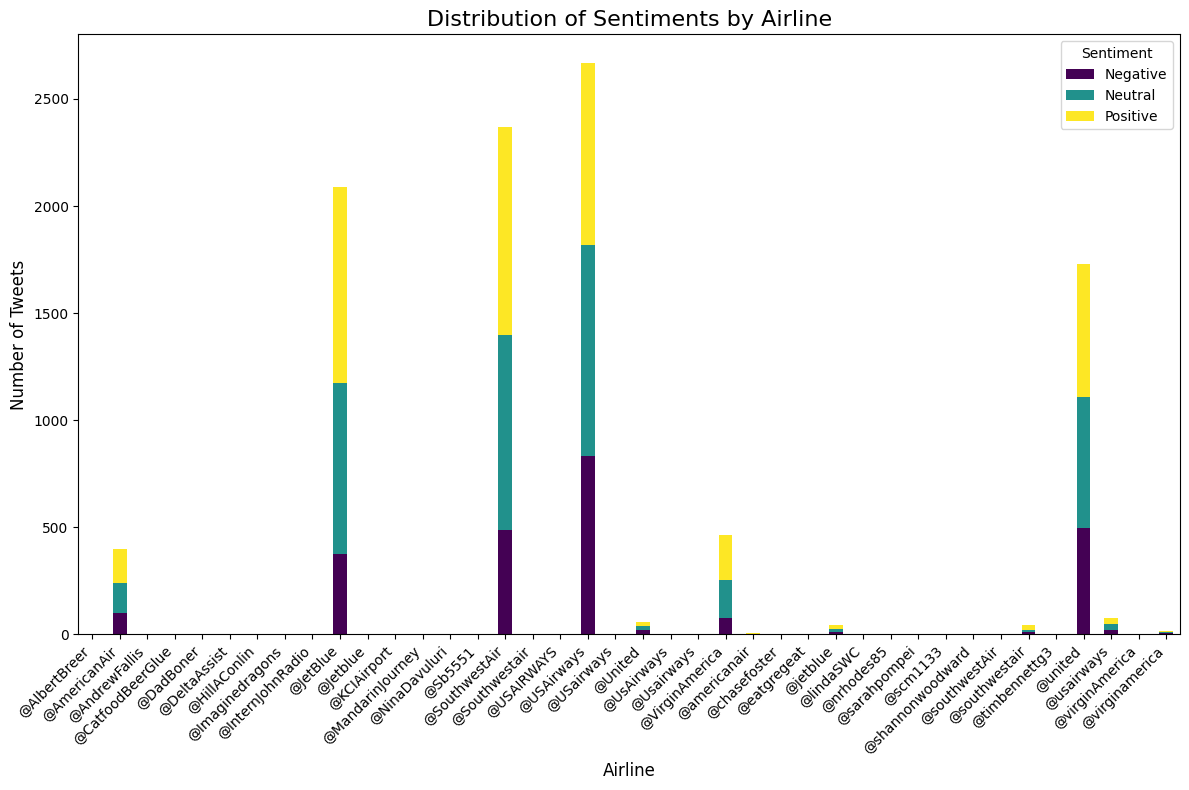

In [ ]:
# 1. การแสดงผล Sentiment สำหรับข้อมูลทั้งหมด
total_sentiment_counts = data['Sentiment'].value_counts() # Fixed column name

# ตรวจสอบว่ามีข้อมูล 'Airline' ใน DataFrame
if 'Airline' in data.columns:
    # นับจำนวน Sentiment แยกตามสายการบิน
    sentiment_counts_airline = data.groupby(['Airline', 'Sentiment']).size().unstack(fill_value=0)

    # สร้าง Stacked Bar Chart
    sentiment_counts_airline.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis")
    plt.title('Distribution of Sentiments by Airline', fontsize=16)
    plt.xlabel('Airline', fontsize=12)
    plt.ylabel('Number of Tweets', fontsize=12)
    plt.xticks(rotation=45, ha='right') # หมุนป้ายแกน x
    plt.legend(title='Sentiment')
    plt.tight_layout()  # ปรับการจัด layout ให้เหมาะสม
    plt.show()
else:
    print("Airline information not available in the dataset.")

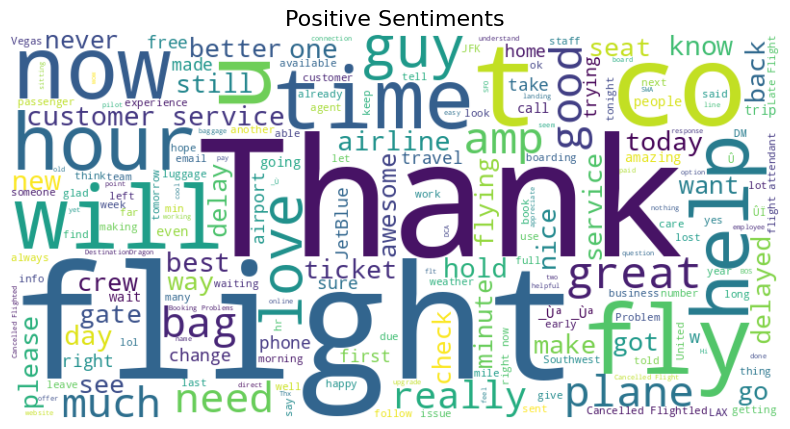

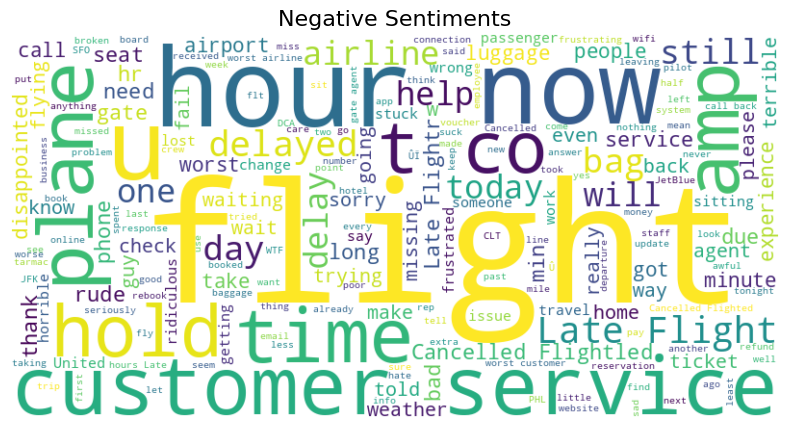

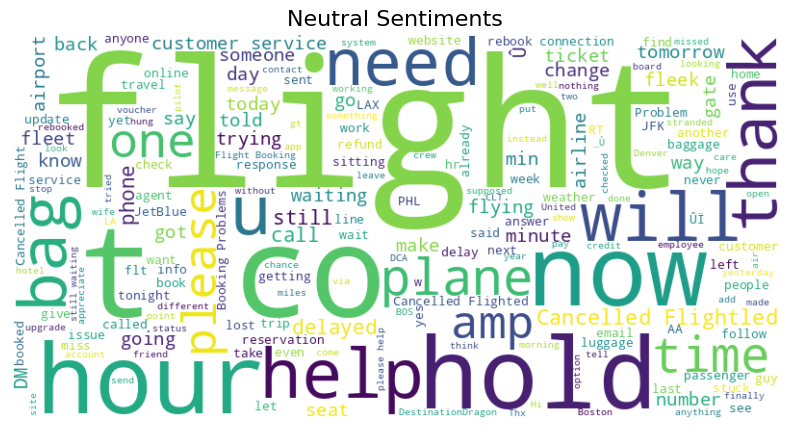

In [ ]:
from wordcloud import WordCloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Separate text based on sentiment
positive_text = ' '.join(data[data['Sentiment'] == 'Positive']['text'].astype(str))
negative_text = ' '.join(data[data['Sentiment'] == 'Negative']['text'].astype(str))
neutral_text = ' '.join(data[data['Sentiment'] == 'Neutral']['text'].astype(str))

# Generate and display word clouds for each sentiment
plot_wordcloud(positive_text, 'Positive Sentiments')
plot_wordcloud(negative_text, 'Negative Sentiments')
plot_wordcloud(neutral_text, 'Neutral Sentiments')